# Merged Data Exploratory Analysis

## Imports

In [104]:
import os 
import gpm # noqa
import pandas as pd
import glob
import xarray as xr
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
from gpm.bucket.writers import preprocess_writer_kwargs
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skbio.stats.ordination import ca
from sklearn.cross_decomposition import CCA, PLSRegression  

In [67]:
FILEPATH = ("/ltenas2/data/GPM_STORM_DB/merged/merged_data_0.parquet") 
df = pd.read_parquet(FILEPATH)

In [68]:
df.describe()

,P_mean,P_std,P_center_count,P_sum,P_max,P_count,MP_sum,MP_contrib,P_GT0_regions,P_GT0_count,...,ICC_40_max,ICC_40_std,Air_temp,gpm_granule_id,time,sunLocalTime,lon,lat,flag_granule_change,patch_id
count,197831.000000,197831.000000,197831.000000,197831.000000,197831.000000,197831.000000,197831.000000,197831.000000,197831.000000,197831.000000,...,41037.000000,41037.000000,197831.000000,197831.000000,197831,197831.000000,197831.000000,197831.000000,197831.0,197831.000000
mean,0.144835,0.655323,79.777406,347.737701,15.760281,184.601306,347.043945,0.972539,14.649362,184.601306,...,47.519620,2.126049,280.284698,7637.237718,2015-07-03 13:06:47.413535232,12.030730,-2.014928,-2.538959,1.0,31.977051
min,0.000360,0.008272,0.000000,0.864467,0.212476,3.000000,0.864467,0.031511,1.000000,3.000000,...,40.040001,0.000000,238.468033,4784.000000,2015-01-01 03:02:22,0.000069,-179.998260,-65.125969,1.0,0.000000
25%,0.008839,0.092140,10.000000,21.218269,1.771047,28.000000,20.145942,0.989800,7.000000,28.000000,...,43.720001,1.049999,270.519867,6262.000000,2015-04-06 03:08:54.500000,5.946757,-99.529831,-37.096638,1.0,15.000000
50%,0.026212,0.202568,26.000000,62.934235,4.169888,68.000000,62.001160,1.000000,12.000000,68.000000,...,46.349998,1.958032,283.407806,7695.000000,2015-07-07 06:33:09,12.065414,-6.295539,-2.492271,1.0,31.000000
75%,0.085659,0.479065,78.000000,205.629318,10.479543,184.000000,205.038811,1.000000,20.000000,184.000000,...,50.290001,3.036417,290.388016,9026.000000,2015-09-30 19:39:35.500000,18.110979,93.788734,29.849772,1.0,47.000000
max,13.715685,31.487974,841.000000,32931.359375,299.999939,2401.000000,32931.359375,1.000000,146.000000,2401.000000,...,64.139999,9.635540,305.877594,10459.000000,2015-12-31 22:47:47,23.999718,179.999329,65.145218,1.0,104.000000
std,0.464696,1.670349,136.261320,1115.737915,41.916309,308.343768,1115.887207,0.077290,10.101789,308.343768,...,4.938528,1.349537,10.966293,1608.518003,NaN,6.956635,108.052137,40.171172,0.0,19.740343


## Cleanup

In [69]:
nan_fractions = df.isna().mean()
nan_fractions = nan_fractions[nan_fractions > 0]  

nan_fractions.sort_values(ascending=False)

ED50_SOLID_max     0.983587
ED50_SOLID_mean    0.983587
ED50_SOLID_std     0.983587
P_GT120_sum        0.972679
P_GT120_mean       0.972679
                     ...   
MA_LP_GT_0         0.138740
MiA_LP_GT_0        0.138740
P_GT1_sum          0.110559
P_GT1_min          0.110559
P_GT1_mean         0.110559
Length: 81, dtype: float64

In [70]:
col_drop_threshold = 0.5  
cols_to_drop = nan_fractions[nan_fractions > col_drop_threshold].index
cols_to_drop

Index(['MA_LP_GT_1', 'MiA_LP_GT_1', 'AR_LP_GT_1', 'MA_LP_GT_2', 'MiA_LP_GT_2',
       'AR_LP_GT_2', 'P_GT5_mean', 'P_GT5_sum', 'P_GT5_min', 'MA_LP_GT_5',
       'MiA_LP_GT_5', 'AR_LP_GT_5', 'P_GT10_mean', 'P_GT10_sum', 'P_GT10_min',
       'MA_LP_GT_10', 'MiA_LP_GT_10', 'AR_LP_GT_10', 'P_GT20_mean',
       'P_GT20_sum', 'P_GT20_min', 'MA_LP_GT_20', 'MiA_LP_GT_20',
       'AR_LP_GT_20', 'P_GT50_mean', 'P_GT50_sum', 'P_GT50_min', 'P_GT80_mean',
       'P_GT80_sum', 'P_GT80_min', 'P_GT120_mean', 'P_GT120_sum',
       'P_GT120_min', 'ED30_SOLID_mean', 'ED30_SOLID_std', 'ED30_SOLID_max',
       'ED40_SOLID_mean', 'ED40_SOLID_std', 'ED40_SOLID_max', 'ED40_FULL_mean',
       'ED40_FULL_std', 'ED40_FULL_max', 'ETH40_mean', 'ETH40_std',
       'ETH40_max', 'ED50_SOLID_mean', 'ED50_SOLID_std', 'ED50_SOLID_max',
       'ED50_FULL_mean', 'ED50_FULL_std', 'ED50_FULL_max', 'ETH50_mean',
       'ETH50_std', 'ETH50_max', 'LCC_40_mean', 'LCC_40_max', 'LCC_40_std',
       'ICC_40_mean', 'ICC_40_max', 'I

## Visualisation

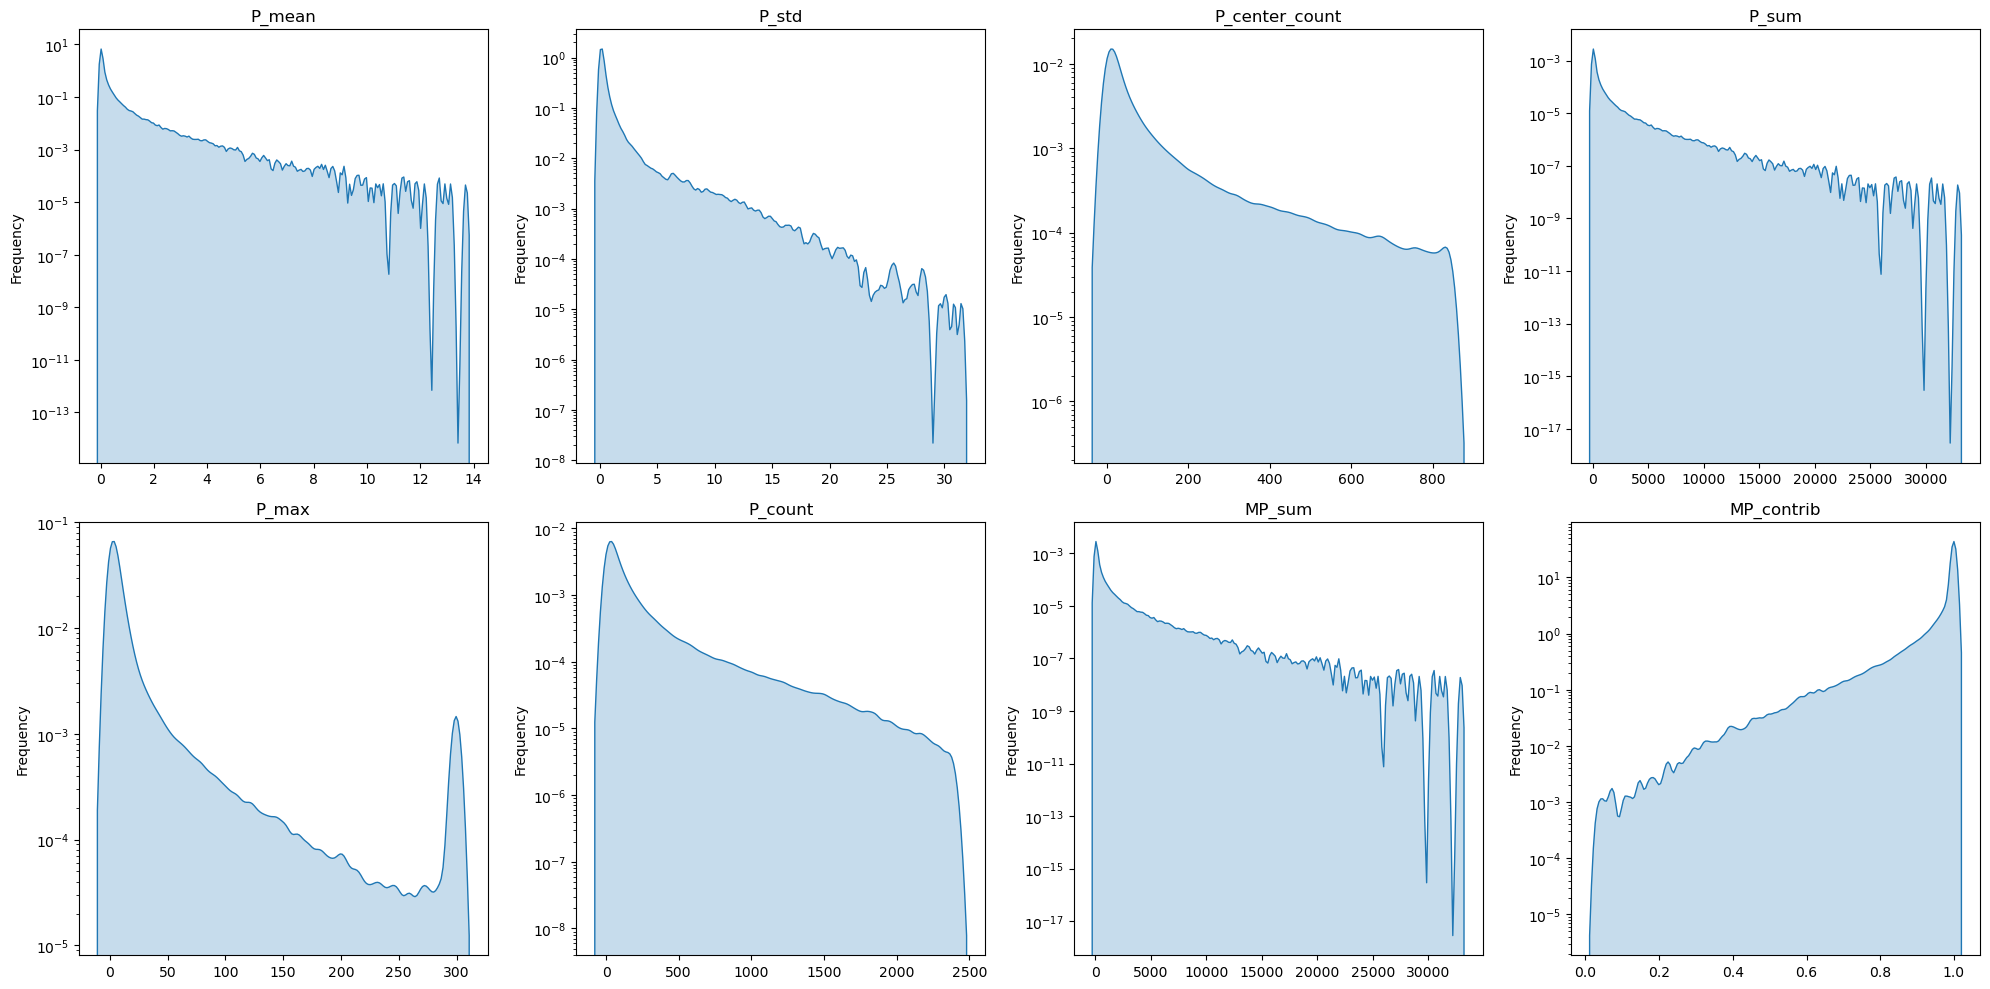

In [71]:
stats = ["P_mean", "P_std", "P_center_count", "P_sum",
         "P_max", "P_count", "MP_sum", "MP_contrib"]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

axes = axes.flatten()

for i, stat in enumerate(stats):
    #sns.histplot(df[stat], bins=50, kde=True, ax=axes[i])
    sns.kdeplot(df[stat], fill=True, ax=axes[i])
    axes[i].set_title(stat)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")
    axes[i].set_yscale("log")

plt.tight_layout()
plt.show()

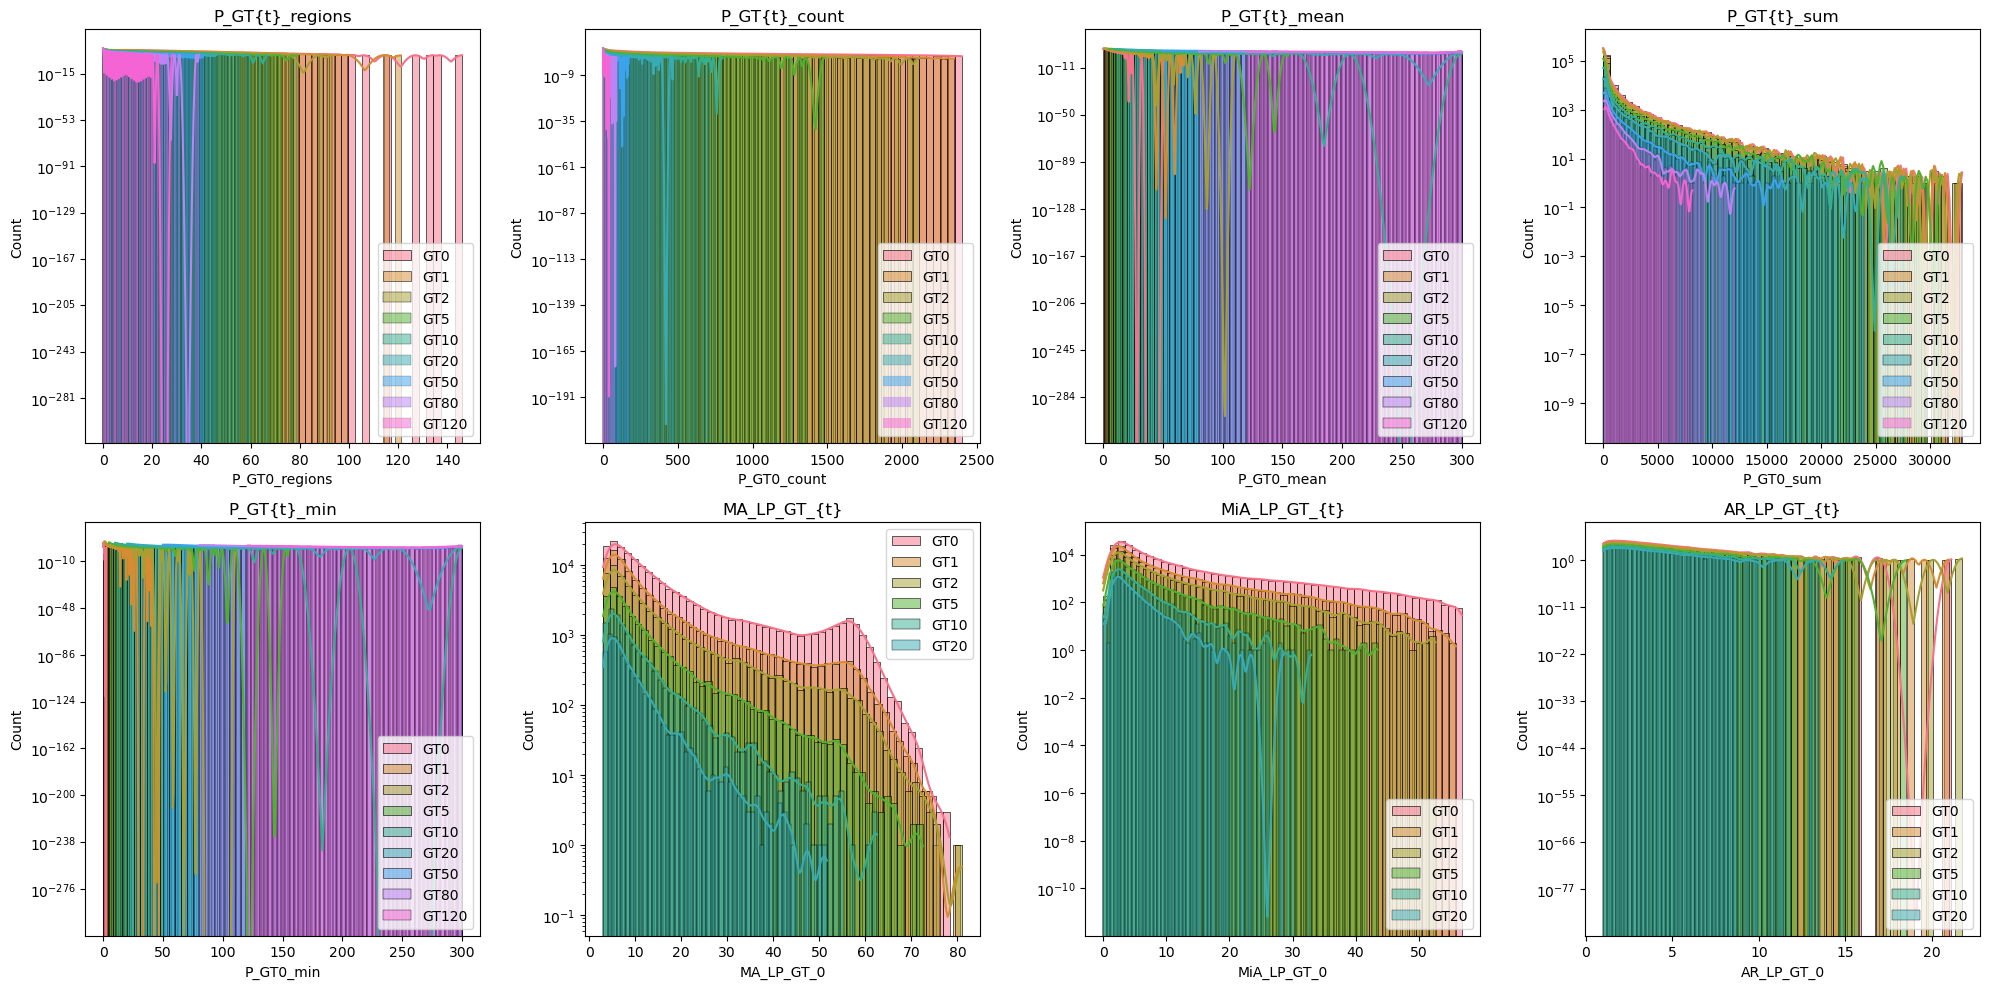

In [72]:
thresholds = [0, 1, 2, 5, 10, 20, 50, 80, 120]
colors = sns.color_palette("husl", len(thresholds))
variables = ["P_GT{t}_regions", "P_GT{t}_count", "P_GT{t}_mean", "P_GT{t}_sum",
             "P_GT{t}_min", "MA_LP_GT_{t}", "MiA_LP_GT_{t}", "AR_LP_GT_{t}"]


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, var_template in enumerate(variables):
    ax = axes[i]
    for j, t in enumerate(thresholds):
        var_name = var_template.format(t=t)
        if var_name in df.columns:  
            sns.histplot(df[var_name], bins=50, kde=True, color=colors[j], 
                         label=f"GT{t}", alpha=0.5, ax=ax)
    
    ax.set_title(var_template.split("{variables}")[0])  
    ax.set_yscale("log") 
    ax.legend()  

plt.tight_layout()
plt.show()

/tmp/ipykernel_4041047/1586896244.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
/tmp/ipykernel_4041047/1586896244.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
/tmp/ipykernel_4041047/1586896244.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
/tmp/ipykernel_4041047/1586896244.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
/tmp/ipykernel_4041047/1586896244.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a F

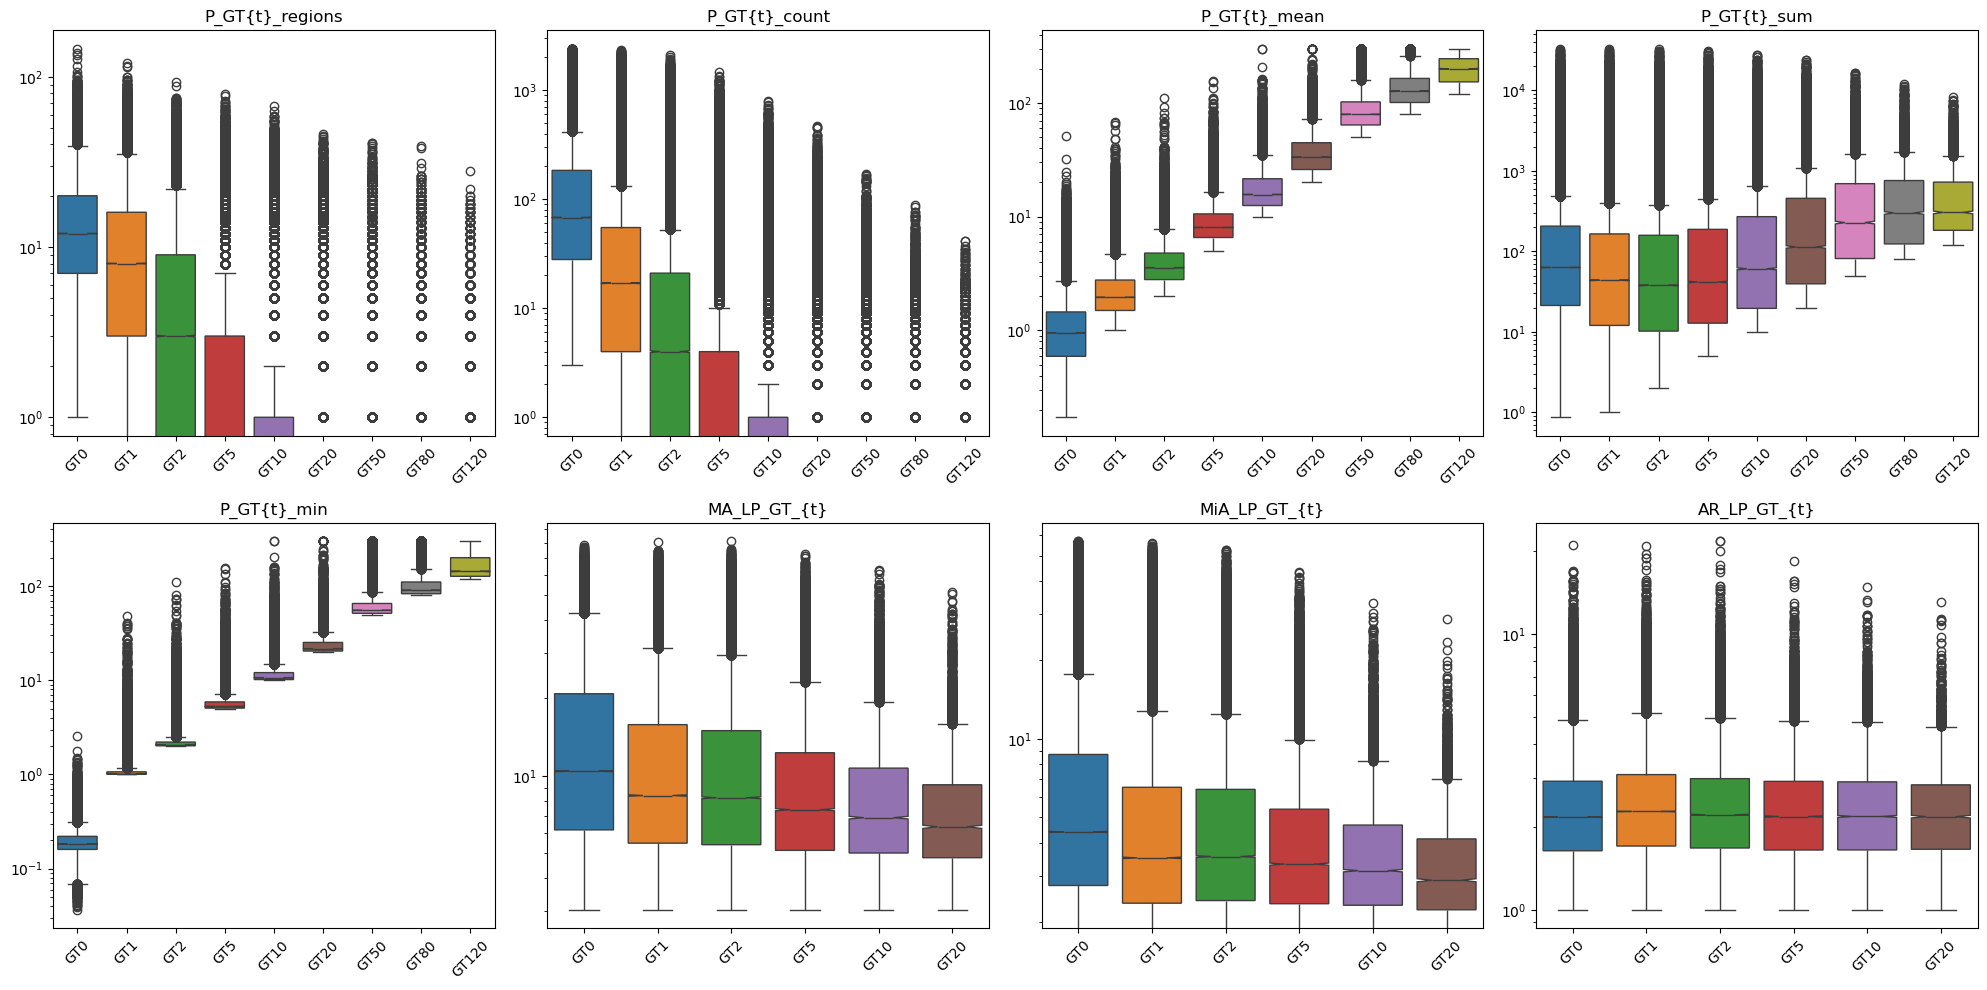

In [73]:
thresholds = [0, 1, 2, 5, 10, 20, 50, 80, 120]
variables = ["P_GT{t}_regions", "P_GT{t}_count", "P_GT{t}_mean", "P_GT{t}_sum",
             "P_GT{t}_min", "MA_LP_GT_{t}", "MiA_LP_GT_{t}", "AR_LP_GT_{t}"]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten() 

for i, var_template in enumerate(variables):
    ax = axes[i]
 
    boxplot_data = []
    labels = []
    
    for t in thresholds:
        var_name = var_template.format(t=t)
        if var_name in df.columns:
            data = df[var_name].dropna()
            boxplot_data.append(data)
            labels.append(f"GT{t}") 

    sns.boxplot(data=boxplot_data, ax=ax, notch=True)

    ax.set_title(variables[i]) 
    ax.set_yscale("log")  
    ax.set_xticklabels(labels, rotation=45)  
    
plt.tight_layout()
plt.show()

In [74]:
vars = df.columns[0:-9]
vars_df = df[vars]

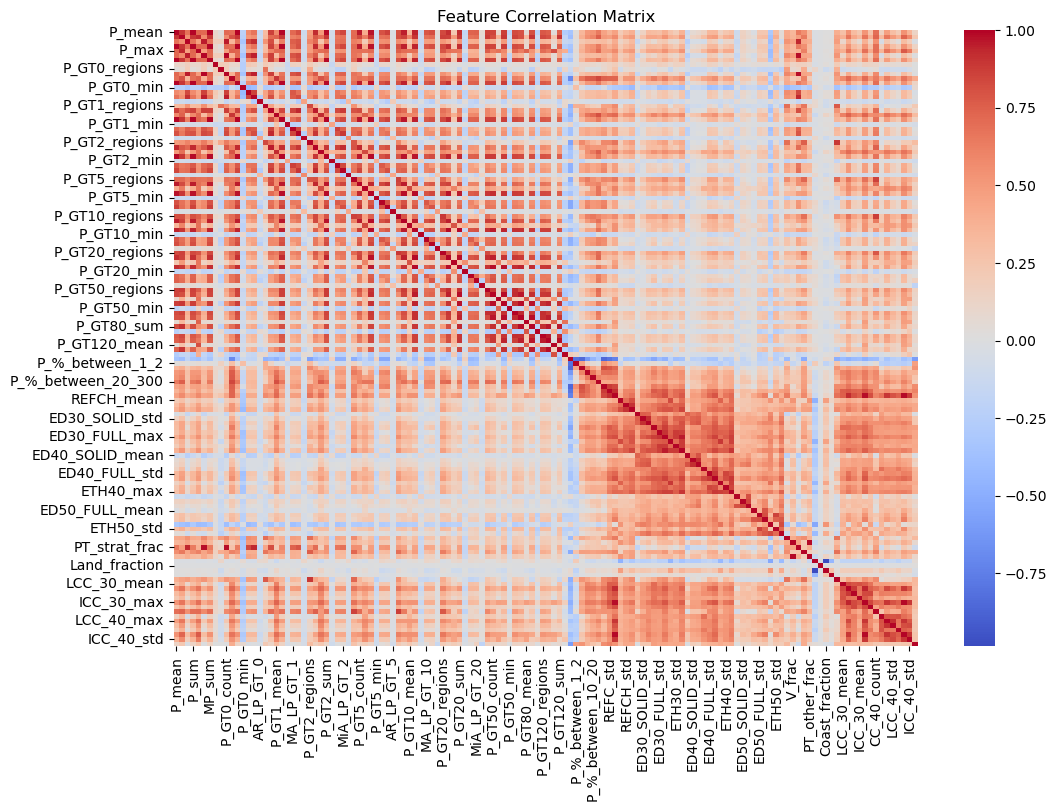

In [75]:

correlation_matrix = vars_df.corr()
plt.figure(figsize=(12, 8))  
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")

plt.title("Feature Correlation Matrix")
plt.show()

In [76]:
corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)

corr_pairs = corr_pairs[corr_pairs < 0.8]

top_n = 50 
top_pairs = corr_pairs.head(top_n).index.tolist()

print(top_pairs)

[('MP_sum', 'MiA_LP_GT_1'), ('MiA_LP_GT_1', 'MP_sum'), ('P_GT0_sum', 'MiA_LP_GT_1'), ('MiA_LP_GT_1', 'P_GT0_sum'), ('MiA_LP_GT_1', 'P_sum'), ('P_sum', 'MiA_LP_GT_1'), ('MiA_LP_GT_1', 'P_mean'), ('P_mean', 'MiA_LP_GT_1'), ('LCC_40_max', 'LCC_40_mean'), ('LCC_40_mean', 'LCC_40_max'), ('P_GT10_count', 'MA_LP_GT_5'), ('MA_LP_GT_5', 'P_GT10_count'), ('ETH30_max', 'ED30_FULL_mean'), ('ED30_FULL_mean', 'ETH30_max'), ('P_GT120_count', 'P_std'), ('P_std', 'P_GT120_count'), ('ETH40_max', 'ED40_FULL_std'), ('ED40_FULL_std', 'ETH40_max'), ('P_GT0_mean', 'P_GT2_mean'), ('P_GT2_mean', 'P_GT0_mean'), ('P_GT50_count', 'MiA_LP_GT_20'), ('MiA_LP_GT_20', 'P_GT50_count'), ('P_GT20_mean', 'P_GT10_mean'), ('P_GT10_mean', 'P_GT20_mean'), ('ETH30_mean', 'REFCH_max'), ('REFCH_max', 'ETH30_mean'), ('ED30_FULL_max', 'REFCH_max'), ('REFCH_max', 'ED30_FULL_max'), ('P_max', 'P_GT20_regions'), ('P_GT20_regions', 'P_max'), ('MiA_LP_GT_5', 'MiA_LP_GT_10'), ('MiA_LP_GT_10', 'MiA_LP_GT_5'), ('P_GT2_sum', 'MA_LP_GT_10'),

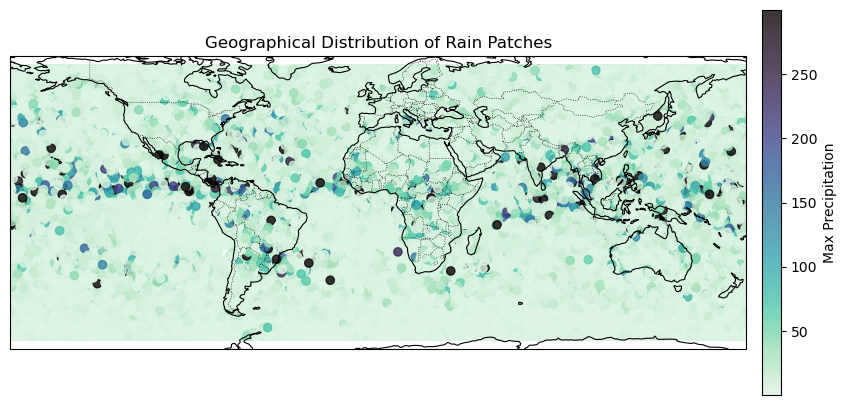

In [77]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

sc = ax.scatter(df["lon"], df["lat"], c=df["P_max"], cmap="mako_r", alpha=0.8, transform=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("Max Precipitation")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Geographical Distribution of Rain Patches")

plt.show()

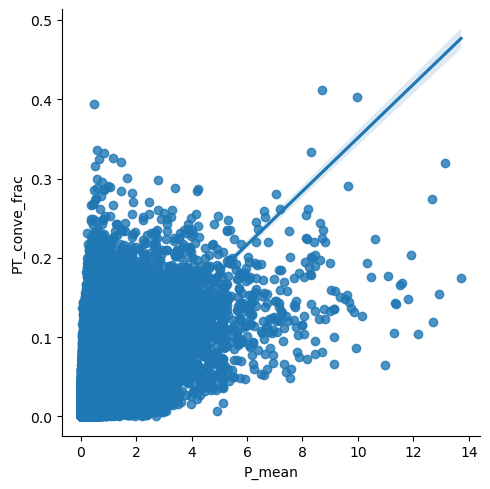

In [78]:
sns.lmplot(data=df, x="P_mean", y="PT_conve_frac")

# PCA

In [81]:
df_cleaned = df.select_dtypes(include=[np.number])


df_cleaned_cols = df_cleaned.dropna(axis=1)
df_cleaned_rows = df_cleaned.dropna(axis=0)

scaler = StandardScaler()
df_scaled_cols = pd.DataFrame(
    scaler.fit_transform(df_cleaned_cols),
    columns=df_cleaned_cols.columns,
    index=df_cleaned_cols.index,
)
df_scaled_rows = pd.DataFrame(
    scaler.fit_transform(df_cleaned_rows),
    columns=df_cleaned_rows.columns,
    index=df_cleaned_rows.index,
)

In [87]:
print(df_scaled_cols.shape)
print(df_scaled_rows.shape)

(197831, 59)
(1056, 140)


In [92]:
# Fit PCA for both cleaned datasets
pca_cols = PCA()
pca_rows = PCA()
pca_cols.fit(df_scaled_cols)
pca_rows.fit(df_scaled_rows)

pc_cols = pca_cols.transform(df_scaled_cols)
pc_rows = pca_rows.transform(df_scaled_rows)

explained_var_cols = np.cumsum(pca_cols.explained_variance_ratio_)
explained_var_rows = np.cumsum(pca_rows.explained_variance_ratio_)

# Select top N most important features for PCA loading arrows
top_n = 5  # Adjust this number
feature_importance_cols = np.abs(pca_cols.components_[0]) + np.abs(pca_cols.components_[1])
feature_importance_rows = np.abs(pca_rows.components_[0]) + np.abs(pca_rows.components_[1])

top_indices_cols = np.argsort(feature_importance_cols)[-top_n:]
top_indices_rows = np.argsort(feature_importance_rows)[-top_n:]

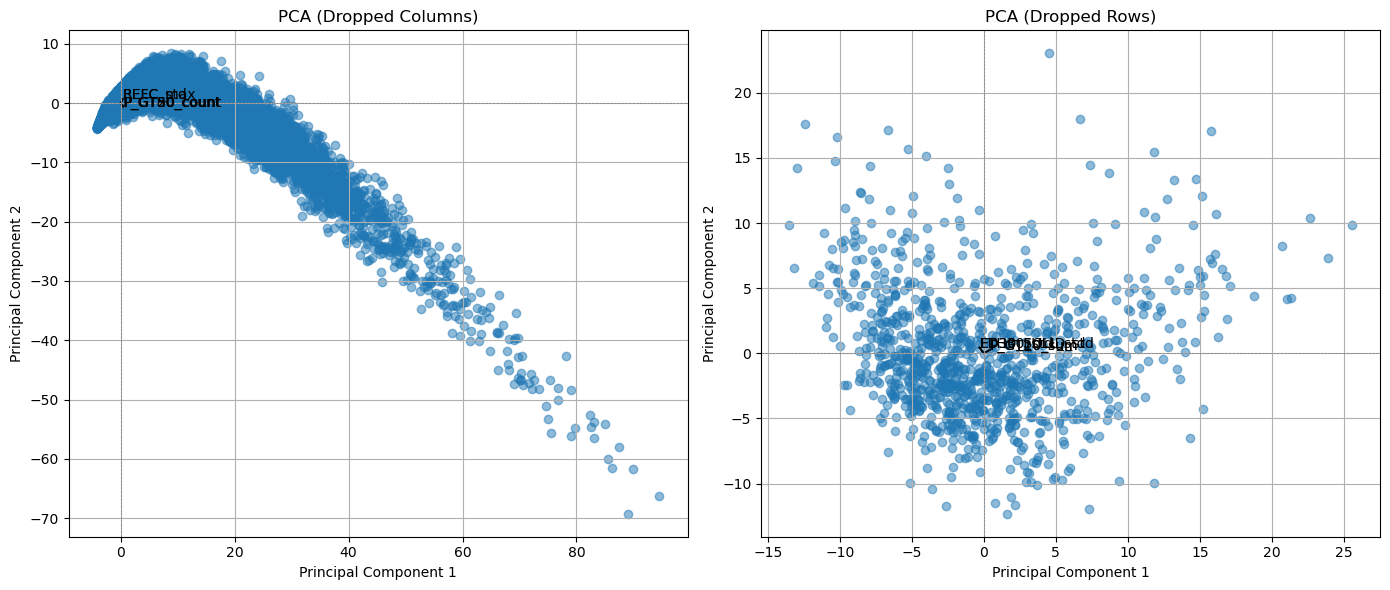

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# **🔹 PCA Scatter Plot - Dropped Columns**
axes[0].scatter(pc_cols[:, 0], pc_cols[:, 1], alpha=0.5, label="Samples")
loadings_cols = pca_cols.components_[:2, :]
for i in top_indices_cols:
    axes[0].arrow(0, 0, loadings_cols[0, i] * 3, loadings_cols[1, i] * 3, alpha=0.7, head_width=0.05)
    axes[0].text(loadings_cols[0, i] * 3, loadings_cols[1, i] * 3, df_scaled_cols.columns[i], fontsize=10)

axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].set_title("PCA (Dropped Columns)")
axes[0].axhline(0, color="grey", linestyle="--", linewidth=0.5)
axes[0].axvline(0, color="grey", linestyle="--", linewidth=0.5)
axes[0].grid()

# **🔹 PCA Scatter Plot - Dropped Rows**
axes[1].scatter(pc_rows[:, 0], pc_rows[:, 1], alpha=0.5, label="Samples")
loadings_rows = pca_rows.components_[:2, :]
for i in top_indices_rows:
    axes[1].arrow(0, 0, loadings_rows[0, i] * 3, loadings_rows[1, i] * 3, alpha=0.7, head_width=0.05)
    axes[1].text(loadings_rows[0, i] * 3, loadings_rows[1, i] * 3, df_scaled_rows.columns[i], fontsize=10)

axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].set_title("PCA (Dropped Rows)")
axes[1].axhline(0, color="grey", linestyle="--", linewidth=0.5)
axes[1].axvline(0, color="grey", linestyle="--", linewidth=0.5)
axes[1].grid()

plt.tight_layout()
plt.show()

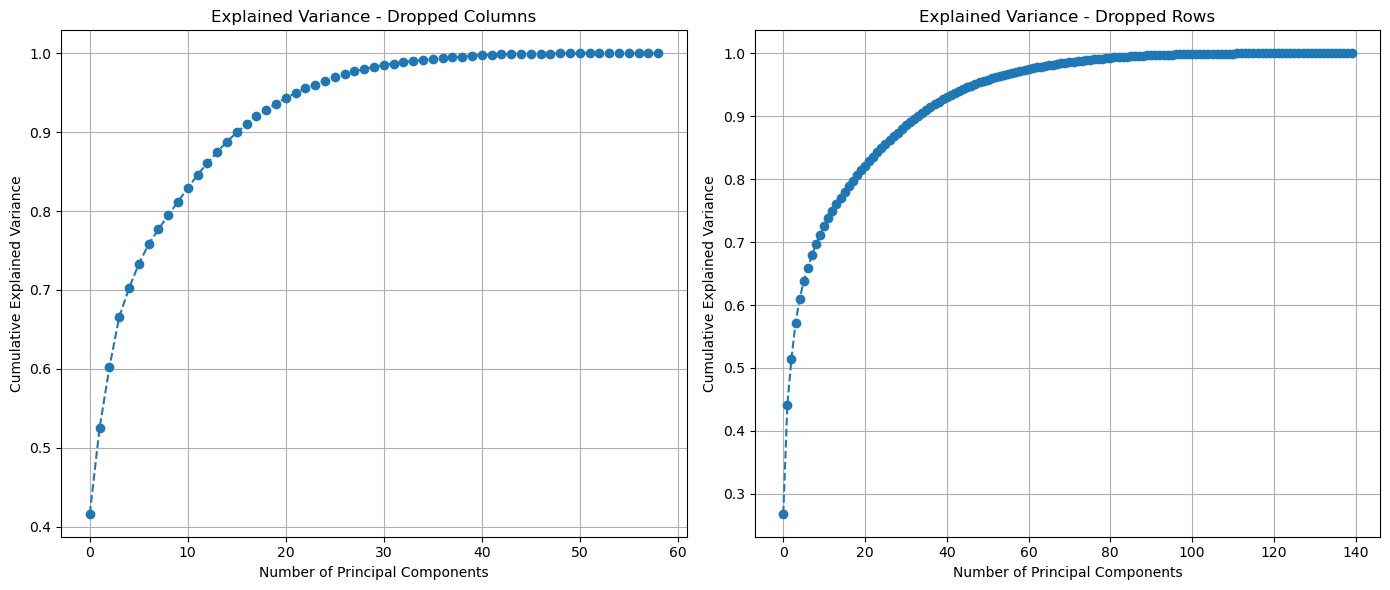

In [95]:
# **🔹 Explained Variance Plots**
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(explained_var_cols, marker="o", linestyle="--", label="Dropped Columns")
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Cumulative Explained Variance")
axes[0].set_title("Explained Variance - Dropped Columns")
axes[0].grid(True)

axes[1].plot(explained_var_rows, marker="o", linestyle="--", label="Dropped Rows")
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Explained Variance - Dropped Rows")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [96]:
# Function to compute optimal number of components
def optimal_pca_components(explained_variance_ratio, threshold=0.95):
    return np.argmax(explained_variance_ratio >= threshold) + 1

# PCA for Dropped Columns
pca_cols = PCA().fit(df_scaled_cols)
num_components_cols = optimal_pca_components(np.cumsum(pca_cols.explained_variance_ratio_))
df_pca_cols = pd.DataFrame(
    PCA(n_components=num_components_cols).fit_transform(df_scaled_cols),
    columns=[f"PC{i}" for i in range(1, num_components_cols + 1)],
)

# PCA for Dropped Rows
pca_rows = PCA().fit(df_scaled_rows)
num_components_rows = optimal_pca_components(np.cumsum(pca_rows.explained_variance_ratio_))
df_pca_rows = pd.DataFrame(
    PCA(n_components=num_components_rows).fit_transform(df_scaled_rows),
    columns=[f"PC{i}" for i in range(1, num_components_rows + 1)],
)

# Print Results
print(f"✅ Retaining {num_components_cols} components (Dropped Columns) to explain 95% variance.")
print(f"✅ Retaining {num_components_rows} components (Dropped Rows) to explain 95% variance.")

✅ Retaining 23 components (Dropped Columns) to explain 95% variance.
✅ Retaining 48 components (Dropped Rows) to explain 95% variance.


## CA

In [107]:
# Run Correspondence Analysis (CA)
ca_results = ca(df_scaled_cols)

# Extract principal components (CA axes)
df_ca = pd.DataFrame(ca_results.samples, columns=[f"CA{i+1}" for i in range(ca_results.samples.shape[1])])

# Plot CA1 vs CA2
plt.figure(figsize=(8, 6))
plt.scatter(df_ca["CA1"], df_ca["CA2"], alpha=0.5)
plt.xlabel("CA1")
plt.ylabel("CA2")
plt.title("Correspondence Analysis (CA)")
plt.axhline(0, color="grey", linestyle="--", linewidth=0.5)
plt.axvline(0, color="grey", linestyle="--", linewidth=0.5)
plt.grid()
plt.show()

ValueError: Input matrix elements must be non-negative.

✅ RDA Completed
✅ CCA Completed


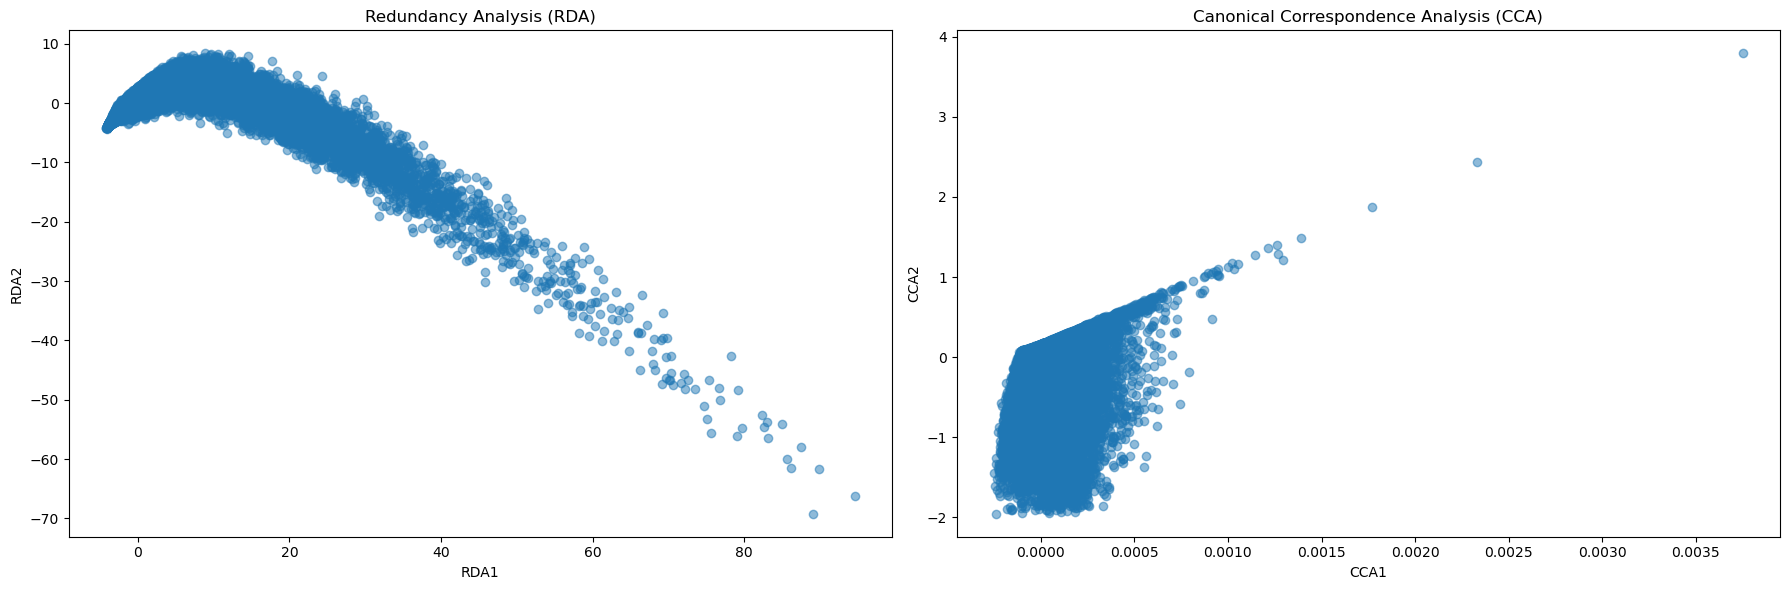

In [108]:
# ---- Redundancy Analysis (RDA) ----
# RDA is often done with PLS-Regression, approximating a PCA with constraints
rda = PLSRegression(n_components=5)  # Choose an appropriate number of components
df_rda = pd.DataFrame(rda.fit_transform(df_scaled_cols, df_scaled_cols)[0], columns=[f"RDA{i+1}" for i in range(5)])
print("✅ RDA Completed")

# ---- Canonical Correspondence Analysis (CCA) ----
# CCA requires a separate set of response (Y) and explanatory (X) variables
X = df_scaled_cols.iloc[:, : df_scaled_cols.shape[1] // 2]  # First half as predictors
Y = df_scaled_cols.iloc[:, df_scaled_cols.shape[1] // 2 :]  # Second half as response

cca = CCA(n_components=5)
df_cca = pd.DataFrame(cca.fit_transform(X, Y)[0], columns=[f"CCA{i+1}" for i in range(5)])
print("✅ CCA Completed")

# ---- Plot DCA, RDA, and CCA results ----
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# RDA Plot
axs[0].scatter(df_rda["RDA1"], df_rda["RDA2"], alpha=0.5)
axs[0].set_title("Redundancy Analysis (RDA)")
axs[0].set_xlabel("RDA1")
axs[0].set_ylabel("RDA2")

# CCA Plot
axs[1].scatter(df_cca["CCA1"], df_cca["CCA2"], alpha=0.5)
axs[1].set_title("Canonical Correspondence Analysis (CCA)")
axs[1].set_xlabel("CCA1")
axs[1].set_ylabel("CCA2")

plt.tight_layout()
plt.show()